# Coca-Cola Stock Price Prediction Project

This project analyzes and predicts Coca-Cola's stock closing price using machine learning.

**Dataset used**: `Coca-Cola_stock_history.csv`  
**Model**: XGBRegressor  
**Goal**: Predict `Close` price and analyze historical trends with technical indicators.


In [3]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [5]:
# Load the Coca-Cola historical stock dataset
data = pd.read_csv("Coca-Cola_stock_history.csv")
data['Date'] = pd.to_datetime(data['Date'], errors='coerce').dt.tz_localize(None)
data = data.sort_values('Date')
data.reset_index(drop=True, inplace=True)
data.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,0.050016,0.051378,0.050016,0.050016,806400,0.0,0
1,1962-01-03,0.049273,0.049273,0.048159,0.048902,1574400,0.0,0
2,1962-01-04,0.049026,0.049645,0.049026,0.049273,844800,0.0,0
3,1962-01-05,0.049273,0.049892,0.048035,0.048159,1420800,0.0,0
4,1962-01-08,0.047787,0.047787,0.046735,0.047664,2035200,0.0,0


In [7]:
# Forward-fill and fill remaining nulls with 0
data.fillna(method='ffill', inplace=True)
data.fillna(0, inplace=True)


C:\Users\mvmak\AppData\Local\Temp\ipykernel_26924\1359567283.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [14]:
# Add Moving Averages, Returns, and Volatility
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()
data['Daily_Return'] = data['Close'].pct_change()
data['Volatility'] = data['Daily_Return'].rolling(window=20).std()

# Long-term trend and momentum indicators
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

# MACD = EMA(12) - EMA(26)
ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26

# Remove rows with NaN due to rolling calculations
data.dropna(inplace=True)
data.head()


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA_20,MA_50,Daily_Return,Volatility,SMA_200,EMA_20,EMA_50,MACD
248,1963-12-31,0.060022,0.060545,0.060022,0.060545,1152000,0.0,0,0.057381,0.054817,0.009827,0.012065,0.047984,0.057752,0.055110,0.001571
249,1964-01-02,0.060545,0.060545,0.059760,0.059760,614400,0.0,0,0.057583,0.055042,-0.012972,0.012676,0.048049,0.057943,0.055292,0.001538
250,1964-01-03,0.059760,0.060022,0.059171,0.059171,499200,0.0,0,0.057767,0.055256,-0.009858,0.012939,0.048111,0.058060,0.055444,0.001448
251,1964-01-06,0.059171,0.059433,0.058647,0.058778,806400,0.0,0,0.057927,0.055459,-0.006638,0.013123,0.048172,0.058128,0.055575,0.001330
252,1964-01-07,0.058778,0.059302,0.058778,0.058778,1152000,0.0,0,0.058084,0.055660,0.000000,0.013134,0.048232,0.058190,0.055700,0.001222


In [15]:
import plotly.graph_objects as go

# Interactive candlestick chart
fig = go.Figure(data=[
    go.Candlestick(x=data['Date'],
                   open=data['Open'],
                   high=data['High'],
                   low=data['Low'],
                   close=data['Close'],
                   name="Candlestick")
])
fig.update_layout(title="Coca-Cola Stock Candlestick Chart",
                  xaxis_title="Date",
                  yaxis_title="Price",
                  xaxis_rangeslider_visible=False)
fig.show()


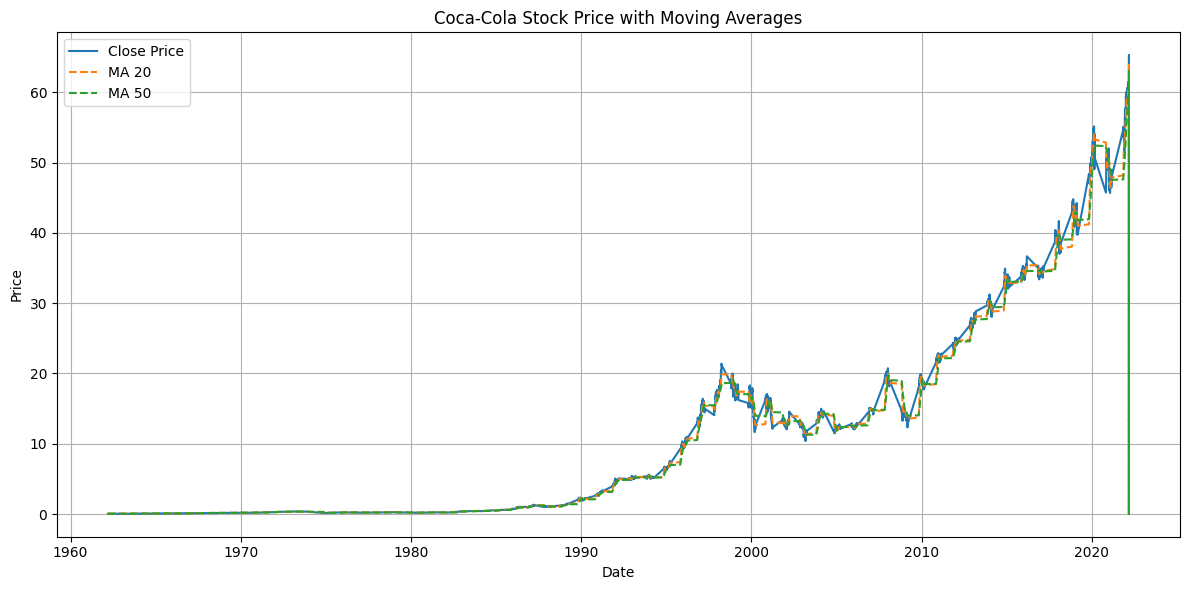

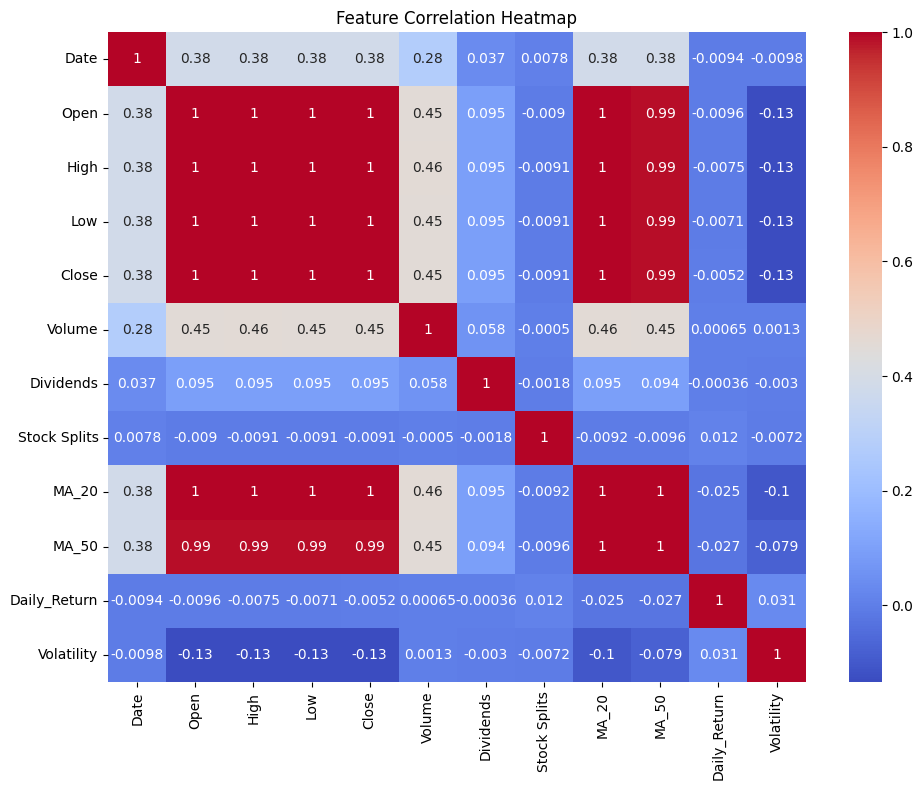

In [9]:
# Line Plot: Close price and moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['MA_20'], '--', label='MA 20')
plt.plot(data['Date'], data['MA_50'], '--', label='MA 50')
plt.title("Coca-Cola Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [10]:
# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits',
            'MA_20', 'MA_50', 'Daily_Return', 'Volatility']
target = 'Close'

X = data[features]
y = data[target]

# Train-test split (no shuffle for time-series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(random_state=42)

In [11]:
# Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("📊 Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


📊 Model Evaluation:
Mean Squared Error (MSE): 0.2077
Mean Absolute Error (MAE): 0.1910


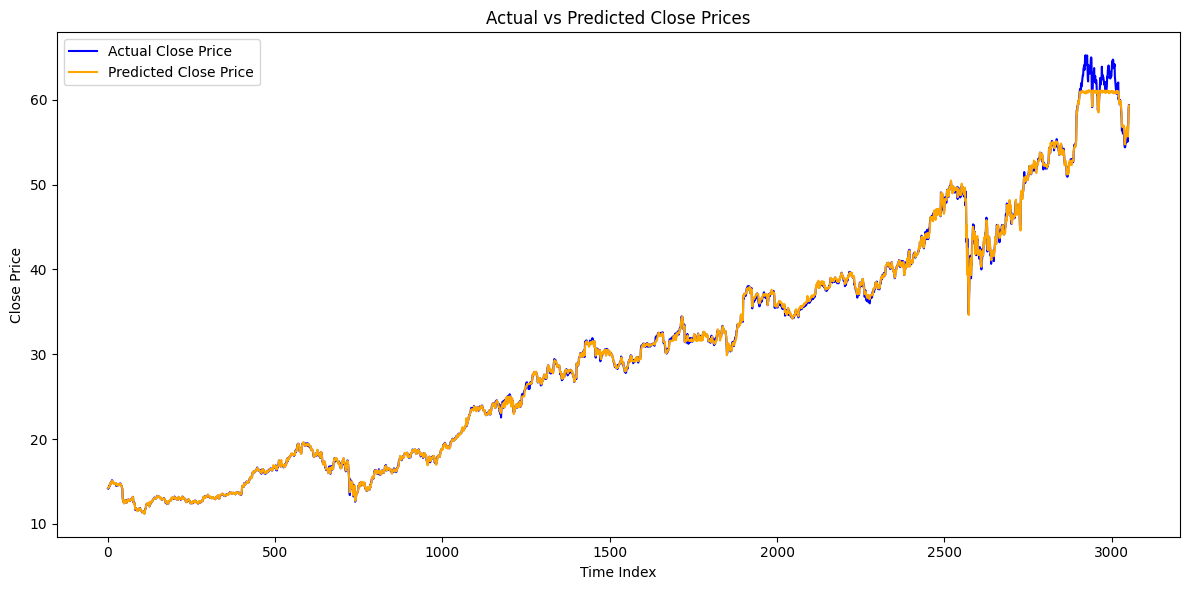

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='orange')
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

# Strategy using Moving Average Cross
class MovingAverageCrossStrategy(Strategy):
    def init(self):
        self.ma20 = self.I(lambda x: pd.Series(x).rolling(20).mean(), self.data.Close)
        self.ma50 = self.I(lambda x: pd.Series(x).rolling(50).mean(), self.data.Close)

    def next(self):
        if crossover(self.ma20, self.ma50):
            self.buy()
        elif crossover(self.ma50, self.ma20):
            self.sell()

bt_data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
bt_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
bt_data.set_index('Date', inplace=True)

bt = Backtest(bt_data, MovingAverageCrossStrategy, cash=10000, commission=0.002)
bt.run()
bt.plot()


C:\Users\mvmak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\backtesting\_plotting.py:55: UserWarning:

Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.



Loading BokehJS ...

C:\Users\mvmak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\backtesting\backtesting.py:954: UserWarning:

time=201: Broker canceled the relative-sized order due to insufficient margin.

C:\Users\mvmak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\backtesting\backtesting.py:954: UserWarning:

time=282: Broker canceled the relative-sized order due to insufficient margin.

C:\Users\mvmak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\backtesting\backtesting.py:954: UserWarning:

time=319: Broker canceled the relative-sized order due to insufficient margin.

C:\Users\mvmak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\backtesting\_stats.py:155: RuntimeWarning:

divide by zero encount

GridPlot(id='p1349', ...)

In [13]:
# Predict for the latest available data point
latest_input = X.iloc[[-1]]
latest_prediction = model.predict(latest_input)

print(f"📌 Predicted Closing Price for the latest data point: ${latest_prediction[0]:.2f}")


📌 Predicted Closing Price for the latest data point: $59.34
